### Logistic Regression  
Applying logistic regression to the breastcancer dataset for binary classification:

**Breast Cancer**:  this dataset is aimed at developing classifiers that can distinguish be-tween malignant and benign tumors in breast cancer.   There are thirty real valued features and 569 instances.


### Task
Implement logistic regression using gradient descent. Do ten-fold cross validation and find the best step-size $\alpha$, using accuracy as the metric. Finally, use the best $\alpha$ you get and re-train the model on the full training data, and report the accuracy, precision and recall.




### A first look at the dataset

In [1]:
# Do not change the code in this cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib notebook

In [2]:
DATA_DIR='breastcancer.csv'
df = pd.read_csv(DATA_DIR, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [3]:
### Implement the loss function for logistic regression
def compute_cost(ip, op, params):
    """
    Cost function in linear regression where the cost is calculated
    ip: input variables
    op: output variables
    params: corresponding parameters
    Returns cost
    """
    num_samples = len(op)
    cost_sum = 0
    c = 0.00001
    for x, y in zip(ip, op):
        sig_WX = sigmoid(sum(params * x))
        #if sig_WX == 1 or sig_WX == 0:
        #    cost_sum += int(y == sig_WX)
        #else:
        cost_sum += y * np.log(sig_WX + c) + (1 - y) * np.log(1 - sig_WX + c)

    cost = -cost_sum / num_samples
    # End code here
    return cost

In [4]:
#the load_data function is written for you
def load_data(data_dir):
    df = pd.read_csv(data_dir)
    data = np.asarray(df.iloc[:, :-1])
    labels = np.asarray(df.iloc[:, -1])
    
    return data, labels

In [5]:
### Implement the sigmoid function 
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


### Batch gradient descent
Algorithm can be given as follows:

```for j in 0 -> max_iteration: 
    for (x_batch,y_batch) in batches: 
        calculate gradient using (x_batch,y_batch)
        update theta
```

In [6]:
def logistic_regression_using_batch_gradient_descent(ip, op, params, alpha, max_iter, batch_size = 1):
#     print ('ip.shape ',ip.shape)
#     print ('op.shape ',op.shape)
#     print ('params.shape ',params.shape)
    """
    Compute the params for linear regression using batch gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    max_iter: maximum number of iterations
    batch_size: size of mini-batches
    Returns parameters, cost, params_store
    """ 
    # initialize iteration, number of samples, cost
    iteration = 0
    num_samples = len(ip)
    cost = np.zeros(max_iter)
    
    # batchify the data into mini-batches
    num_batch = int(num_samples / batch_size)
    batches = []
    for i in range(num_batch - 1):
        x_batch = ip[i*batch_size:(i + 1)*batch_size]
        y_batch = op[i*batch_size:(i + 1)*batch_size]
        batches.append((np.asarray(x_batch), np.asarray(y_batch)))
    i += 1
    x_batch = ip[i * batch_size:len(ip)]
    y_batch = op[i * batch_size:len(op)]
    batches.append((np.asarray(x_batch), np.asarray(y_batch)))

    # Compute the cost and store the params for the corresponding cost
    while iteration < max_iter:
        cost[iteration] = compute_cost(ip, op, params)
        
        for x_batch,y_batch in batches:
            O_minus_y = np.array([sigmoid(sum(params * x_batch[i])) for i in range(len(x_batch))]) - y_batch    
            gradient = np.dot(x_batch.T, O_minus_y)
            params -= alpha * gradient/len(y_batch)
            
        iteration += 1
    
    return params, cost

In [7]:
def evaluate(x_test, y_test,params):
    """
    Evaluate the model, return the accuracy, precision and recall
    x_test: input variables 
    y_test: labels
    params: corresponding parameters
    """ 
    y_predict = []
    true_positive = 0
    #false_positive = 0
    #false_negative = 0
    # sum(params * x_test[i]) > 0 means W_T * x > 0 and sigmoid(W_T * x) > 0.5, 
    # which means the predict is 1
    for i in range(x_test.shape[0]):
        y_predict.append( int(sum(params * x_test[i]) > 0))
        if int(sum(params * x_test[i]) > 0) == 1 and y_test[i] == 1:
          true_positive += 1
        #if int(sum(params * x_test[i]) > 0) == 1 and y_test[i] == 0:
        #  false_positive += 1
        #if int(sum(params * x_test[i]) > 0) == 0 and y_test[i] == 1:
        #  false_negative += 1

    acc = np.sum(y_predict == y_test) / y_test.shape[0]

    #precision = true_positive / (true_positive + false_positive)
    #recall = true_positive / (true_positive + false_negative)
    precision = true_positive / sum(y_predict)
    recall = true_positive / sum(y_test)
    return acc, precision, recall
            


In [8]:
def cross_validation(x_train_full, y_train_full, k, alpha, max_iter, batch_size):
    """
    For a given set of hyper-parameters, do k-fold cross_validation, return the average accuracy.
    x_train_full: the full training data
    y_test: the full training labels
    k: number of folds to divide the whole traiing set
    alpha: step-size for Gradient Descent
    max_iter: maximum number of iterations
    batch_size: size of mini-batches
    Return the average accuracy
    """
    #split the data into k-folds
    all_accs = []
    num_samples = y_train_full.shape[0]
    fold_size = int(y_train_full.shape[0] / k)
    # Shuffle the data
    shuffler = np.random.permutation(len(y_train_full))
    x_train_shuffled = x_train_full[shuffler]
    y_train_shuffled = y_train_full[shuffler]
    # Generate fold index
    fold_idx = {}
    for i in range(k - 1):
        fold_idx[i] = np.array(range(i * fold_size, i * fold_size + fold_size))
    i += 1
    fold_idx[i] = np.array(range(i * fold_size, x_train_shuffled.shape[0]))

    for idx in range(k):
        ###during each iteration, we hold out one hold for evaluation, and use the rest as training data
        train_index = np.delete(np.array(range(x_train_shuffled.shape[0])), fold_idx[idx])
        x_train = x_train_shuffled[train_index]
        y_train = y_train_shuffled[train_index]
        x_eval = x_train_shuffled[fold_idx[idx]]
        y_eval = y_train_shuffled[fold_idx[idx]]
        # train the data
        #initial_params_guess = np.ones(x_train_full.shape[1]) / 1000
        initial_params_guess = np.zeros(x_train_full.shape[1])
        params, cost = logistic_regression_using_batch_gradient_descent(x_train, y_train, initial_params_guess,
                                                                  alpha, max_iter, batch_size)
        #After figuring out the training and eval data, train you model and evaluate it to get the accuracy.
        acc, precision, recall = evaluate(x_eval, y_eval, params)
        all_accs.append(acc)
    average_acc = sum(all_accs)/k
    return average_acc

### Cross-validation to find the best alpha

In [9]:
#Set your DATA_DIR
DATA_DIR='breastcancer.csv'
# Do not change the code below
# Train the model
from sklearn.model_selection import train_test_split
#reserve the test data, do not use them for cross-validation!
data, labels = load_data(DATA_DIR)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20)
x_train = np.append(x_train, np.ones((x_train.shape[0],1)), axis=1)
x_test = np.append(x_test, np.ones((x_test.shape[0],1)), axis=1)

## For each possible value of alpha, do cross-validation
##compare the average accuracies and choose the best alpha
alphas = [5e-4,1e-4,5e-3,1e-3,5e-2]
max_iter = 200
batch_size =16
cv_results =[]
for alpha in alphas:
    average_acc = cross_validation(x_train, y_train, 10, alpha, max_iter, batch_size)
    cv_results.append([average_acc,alpha])
cv_results.sort()
print (cv_results)
best_alpha = cv_results[-1][1]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


[[0.7853514739229025, 0.0001], [0.8672108843537416, 0.005], [0.8831292517006801, 0.05], [0.9036734693877552, 0.001], [0.9181405895691611, 0.0005]]


### Re-train on the whole training set with the best alpha, report results on test data.


In [10]:
# Do not change the code in this cell
# Re-train the model using the best alpha you picked
# Report the final results

params = np.zeros(x_train.shape[1])
params, costs =\
    logistic_regression_using_batch_gradient_descent(x_train, y_train, params, best_alpha, max_iter, batch_size=10)
final_acc,final_precision,final_recall = evaluate(x_test, y_test,params)
print ('Final results : Accuracy:{:.2f}, Precision:{:.2f},Recal:{:.2f}'.format(final_acc,final_precision,final_recall))

Final results : Accuracy:0.91, Precision:0.91,Recal:0.88


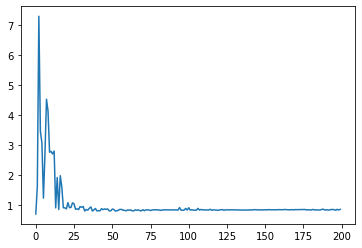

In [11]:
plt.plot(costs)